In [6]:
import fastbook
fastbook.setup_book()

In [7]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

In [8]:
# Downloading the data the usual way
path = untar_data(URLs.ML_100k)

# Extracting the Ratings
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])

# Extracting the Movie Titles
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                    usecols=(0,1), names=('movie', 'title'), header=None)

# Merging the two dataframes
ratings = ratings.merge(movies)

# Creating our DataLoaders
dls = CollabDataLoaders.from_df(ratings,
                                 user_name='user',
                                 item_name='title',
                                 rating_name = 'rating',
                                 bs=64)

# Initialising our Latent Factors
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [9]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

# Collaborative Filtering Deep Dive

## Creating our Own Embedding Module

So far, we have used `Embedding` without thinking about how it really works. Let's recreate `DotProductBias` *without* using this class. We'll need a randomly initialised weight matrix for each of these embeedings. We have to be careful however, as optimisers require that they can get all the parameters of a module from the module's `parameter` method. This does not happen automatically, so we need to tell `Module` that we want to treat a tensor as a parameter by wrapping it in the `nn.Parameter` class. This class doesn't add any functionality (other than automatically calling `requires_grad_` for us).

All PyTorch modules use `nn.Parameter` for any trainable parameters, which is why we haven't needed to explicitly use this wrapper up until now. To create a tensor as a parameter with random initialisation, we can define the following function.

In [10]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Let's use this to create `DotProductBias` again, but without `Embedding`:

In [11]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

Let's train it again too check we get around the same results we saw in the previous section.

In [12]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.921794,0.944033,00:03
1,0.859806,0.868487,00:03
2,0.712489,0.834484,00:03
3,0.599874,0.820401,00:03
4,0.490464,0.820748,00:03


## Interpreting Embeddings and Biases

Let's have a look at what our model has learned.

### Biases
Our model is already useful, in that it can provide us with movie recommendations for our users - but it is also interesting to see what parameters it has discovered. The easiest to interpret are the biases.

Below are the movies with the lowest values in the bias vector.

In [13]:
movie_bias = learn.model.movie_bias.squeeze()
idx = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idx]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Bio-Dome (1996)',
 'Bloodsport 2 (1995)',
 'Cable Guy, The (1996)']

These results tell us that for each of these movies, even when a user is very well matched to its latent factors, they still generally don't like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy.

By the same token, below are the movies with the highest bias.

In [14]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)",
 'Usual Suspects, The (1995)']

This tells that even if you don't normally enjoy detective movies, you might still enjoy *LA Confidential*.

### Embedding Matrices

It is not quite so easy to interpret the embedding matrices, as there are just too many factors for a human to look at. But we can pull out the most important underlying *directions* in such a matrix by using *principal component analysis (PCA)*. 

Below shows what our movies look like based on two of the strongest PCA components.

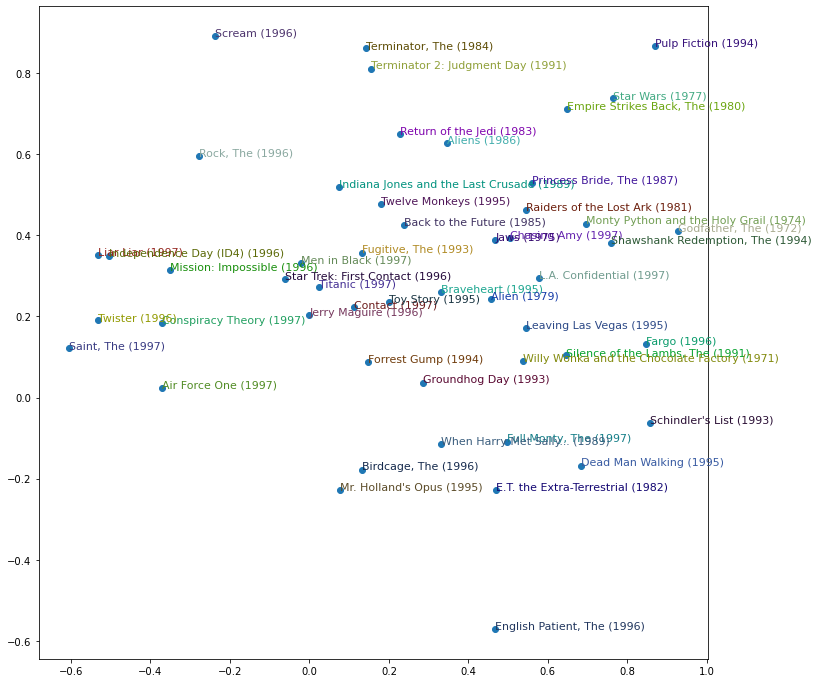

In [15]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

What we can see above is that the model seems to have discovered a concept of *classic* versus *pop culture* movies, or perhaps it is *critically acclaimed*.